In [3]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st

In [ ]:
# Data - ABCD
# reporter - child
# Hypothesis - Hyp1 (depressed vs not depressed)
# Target AUCROC = 0.8

In [4]:
path_to_ksads_data = '/data/ABCD_MBDU/release3-tabulated-data/abcd_ksad501.txt' # this is the child-report K-SADS we are comparing against
path_to_cbcl_data = '/data/ABCD_MBDU/release3-tabulated-data/abcd_cbcls01.txt'

# Loading ksads baseline data

In [10]:
# Load baseline data, leave only the columns with the relevant diagnoses

In [11]:
ksads_data = pd.read_csv(path_to_ksads_data, sep='\t', header=0, low_memory=False)

long_names = ksads_data.loc[0].to_dict()
ksads_data = ksads_data.drop(0)

ksads_data_bsl = ksads_data.loc[ksads_data.eventname == 'baseline_year_1_arm_1'].copy()
ksads_data_bsl.head()

,collection_id,abcd_ksad501_id,dataset_id,subjectkey,src_subject_id,interview_date,interview_age,sex,eventname,ksads_import_id_t,...,ksads_10_47_t,ksads_11_51_t,ksads_12_65_t,ksads_13_75_t,ksads_14_90_t,ksads_25_33_t,ksads_timestamp_t,ksads_duration_t,collection_title,study_cohort_name
2,2573,143640,34614,NDAR_INV00BD7VDC,NDAR_INV00BD7VDC,06/12/2018,112,M,baseline_year_1_arm_1,NDAR_INV00BD7VDC_baselineyear1arm1_01,...,0,555,555,555,555,555,06-12-2018 11:17,11,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
3,2573,143643,34614,NDAR_INV00CY2MDM,NDAR_INV00CY2MDM,08/22/2017,130,M,baseline_year_1_arm_1,NDAR_INV00CY2MDM_baselineyear1arm1_01,...,0,555,555,555,555,555,08-22-2017 11:42,5,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
6,2573,143656,34614,NDAR_INV00NPMHND,NDAR_INV00NPMHND,03/21/2017,118,F,baseline_year_1_arm_1,555,...,0,555,555,555,555,555,03-21-2017 06:13,9,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
7,2573,143658,34614,NDAR_INV00R4TXET,NDAR_INV00R4TXET,04/10/2018,114,F,baseline_year_1_arm_1,NDAR_INV00R4TXET_baselineyear1arm1_01,...,0,555,555,555,555,555,04-10-2018 03:14,6,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
8,2573,143662,34614,NDAR_INV00UMK5VC,NDAR_INV00UMK5VC,09/12/2018,119,F,baseline_year_1_arm_1,NDAR_INV00UMK5VC_baselineyear1arm1_01,...,0,555,555,555,555,555,09-12-2018 01:14,26,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release


## ksads - only leave columns with name id and depression diagnosis

In [12]:
depression_column_list = [f'ksads_1_{x}_t' for x in [840, 841, 843, 844, 846]]
col_list = ['src_subject_id']
col_list += depression_column_list

col_list

['src_subject_id',
 'ksads_1_840_t',
 'ksads_1_841_t',
 'ksads_1_843_t',
 'ksads_1_844_t',
 'ksads_1_846_t']

In [13]:
ksads_bsl_id_alldep = ksads_data_bsl.loc[:, col_list]
ksads_bsl_id_alldep.head()

,src_subject_id,ksads_1_840_t,ksads_1_841_t,ksads_1_843_t,ksads_1_844_t,ksads_1_846_t
2,NDAR_INV00BD7VDC,0,0,0,0,0
3,NDAR_INV00CY2MDM,0,0,0,0,0
6,NDAR_INV00NPMHND,0,0,0,0,0
7,NDAR_INV00R4TXET,0,0,0,0,0
8,NDAR_INV00UMK5VC,0,0,0,0,0


In [14]:
ksads_dict_data = ksads_bsl_id_alldep.to_dict('records')
ksads_dict_data[:5]

[{'src_subject_id': 'NDAR_INV00BD7VDC',
  'ksads_1_840_t': '0',
  'ksads_1_841_t': '0',
  'ksads_1_843_t': '0',
  'ksads_1_844_t': '0',
  'ksads_1_846_t': '0'},
 {'src_subject_id': 'NDAR_INV00CY2MDM',
  'ksads_1_840_t': '0',
  'ksads_1_841_t': '0',
  'ksads_1_843_t': '0',
  'ksads_1_844_t': '0',
  'ksads_1_846_t': '0'},
 {'src_subject_id': 'NDAR_INV00NPMHND',
  'ksads_1_840_t': '0',
  'ksads_1_841_t': '0',
  'ksads_1_843_t': '0',
  'ksads_1_844_t': '0',
  'ksads_1_846_t': '0'},
 {'src_subject_id': 'NDAR_INV00R4TXET',
  'ksads_1_840_t': '0',
  'ksads_1_841_t': '0',
  'ksads_1_843_t': '0',
  'ksads_1_844_t': '0',
  'ksads_1_846_t': '0'},
 {'src_subject_id': 'NDAR_INV00UMK5VC',
  'ksads_1_840_t': '0',
  'ksads_1_841_t': '0',
  'ksads_1_843_t': '0',
  'ksads_1_844_t': '0',
  'ksads_1_846_t': '0'}]

In [15]:
# Removing missing data
# KSADS is binary. Cells with '555' and '888' indicate missing data. 
# We replace cells with valus >1 with nans and remove them
ksads_bsl_id_alldep = ksads_bsl_id_alldep.set_index('src_subject_id')
ksads_bsl_id_alldep = ksads_bsl_id_alldep.astype(int)
ksads_bsl_id_alldep[ksads_bsl_id_alldep > 1] = np.nan

nnans = ksads_bsl_id_alldep.isnull().sum(1)
bad_ids = nnans[nnans > 1].index
good_ids = nnans[nnans == 0].index

ksads_dat = (ksads_bsl_id_alldep.loc[good_ids].sum(1) > 0).astype(int)
ksads_dat.sum()

120

In [16]:
'''ksads_depression_dict = {}

check_counter = 0
for datadict in ksads_dict_data:
    current_id = datadict['src_subject_id']
    if datadict['ksads_1_840_t'] == '1' or datadict['ksads_1_841_t'] == '1' or datadict['ksads_1_843_t'] == '1' or datadict['ksads_1_844_t'] == '1' or datadict['ksads_1_846_t'] == '1':
        print(current_id)
        check_counter +=1
        current_ksads = 1
    else:
        current_ksads = 0
    ksads_depression_dict[current_id] = current_ksads
            
print(ksads_depression_dict) 
print(len(ksads_depression_dict))
print(check_counter)'''

"ksads_depression_dict = {}\n\ncheck_counter = 0\nfor datadict in ksads_dict_data:\n    current_id = datadict['src_subject_id']\n    if datadict['ksads_1_840_t'] == '1' or datadict['ksads_1_841_t'] == '1' or datadict['ksads_1_843_t'] == '1' or datadict['ksads_1_844_t'] == '1' or datadict['ksads_1_846_t'] == '1':\n        print(current_id)\n        check_counter +=1\n        current_ksads = 1\n    else:\n        current_ksads = 0\n    ksads_depression_dict[current_id] = current_ksads\n            \nprint(ksads_depression_dict) \nprint(len(ksads_depression_dict))\nprint(check_counter)"

In [17]:
# ksads_bsl_id_dep = pd.DataFrame.from_dict(ksads_depression_dict, orient='index')
# ksads_bsl_id_dep.head(20)

In [18]:
# ksads_bsl_id_dep = ksads_bsl_id_dep.rename(columns={0: 'ksads_dep_binary'})
# #ksads_bsl_id_dep = ksads_bsl_id_dep.rename_axis("subject_id").reset_index()
# ksads_bsl_id_dep.head(20)

In [19]:
ksads_bsl_id_dep = pd.DataFrame(ksads_dat).rename(columns = {0:'ksads_dep_binary'})
ksads_bsl_id_dep.head()

,ksads_dep_binary
src_subject_id,
NDAR_INV00BD7VDC,0
NDAR_INV00CY2MDM,0
NDAR_INV00NPMHND,0
NDAR_INV00R4TXET,0
NDAR_INV00UMK5VC,0


# Load cbcl data

In [20]:
cbcl_data = pd.read_csv(path_to_cbcl_data, sep='\t', header=0, low_memory=False)
cbcl_data.head()

,collection_id,abcd_cbcls01_id,dataset_id,subjectkey,src_subject_id,interview_date,interview_age,sex,eventname,cbcl_scr_syn_anxdep_r,...,cbcl_scr_07_ocd_r,cbcl_scr_07_ocd_t,cbcl_scr_07_ocd_m,cbcl_scr_07_ocd_nm,cbcl_scr_07_stress_r,cbcl_scr_07_stress_t,cbcl_scr_07_stress_m,cbcl_scr_07_stress_nm,collection_title,study_cohort_name
0,collection_id,abcd_cbcls01_id,dataset_id,The NDAR Global Unique Identifier (GUID) for research subject,Subject ID how it's defined in lab/project,Date on which the interview/genetic test/sampling/imaging/biospecimen was completed. MM/DD/YYYY,Age in months at the time of the interview/test/sampling/imaging.,Sex of the subject,The event name for which the data was collected,AnxDep CBCL Syndrome Scale (raw score),...,Obsessive-Compulsive Problems (OCD) CBCL Scale2007 Scale (raw score),Obsessive-Compulsive Problems (OCD) CBCL Scale2007 Scale (t-score),Obsessive-Compulsive Problems (OCD) CBCL Scale2007 Scale (missing values),Obsessive-Compulsive Problems (OCD) CBCL Scale2007 Scale (number of missing values),Stress CBCL Scale2007 Scale (raw score),Stress CBCL Scale2007 Scale (t-score),Stress CBCL Scale2007 Scale (missing values),Stress CBCL Scale2007 Scale (number of missing values),collection_title,study_cohort_name
1,2573,76906,34967,NDAR_INV003RTV85,NDAR_INV003RTV85,10/01/2018,131,F,baseline_year_1_arm_1,0,...,0,50,NaN,0,0,50,NaN,0,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
2,2573,76922,34967,NDAR_INV00LH735Y,NDAR_INV00LH735Y,01/29/2018,109,M,baseline_year_1_arm_1,0,...,0,50,NaN,0,1,50,NaN,0,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
3,2573,76930,34967,NDAR_INV00U4FTRU,NDAR_INV00U4FTRU,05/11/2019,141,F,1_year_follow_up_y_arm_1,10,...,8,76,NaN,0,18,81,NaN,0,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
4,2573,76932,34967,NDAR_INV00UMK5VC,NDAR_INV00UMK5VC,09/25/2019,132,F,1_year_follow_up_y_arm_1,1,...,0,50,NaN,0,4,54,NaN,0,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release


In [21]:
cbcl_data = cbcl_data.drop(0)

cbcl_data_bsl = cbcl_data.loc[cbcl_data.eventname == 'baseline_year_1_arm_1'].copy()
#bsl_dat = ksads_dat.loc[ksads_dat.eventname == '2_year_follow_up_y_arm_1'].copy()
cbcl_data_bsl.head()

,collection_id,abcd_cbcls01_id,dataset_id,subjectkey,src_subject_id,interview_date,interview_age,sex,eventname,cbcl_scr_syn_anxdep_r,...,cbcl_scr_07_ocd_r,cbcl_scr_07_ocd_t,cbcl_scr_07_ocd_m,cbcl_scr_07_ocd_nm,cbcl_scr_07_stress_r,cbcl_scr_07_stress_t,cbcl_scr_07_stress_m,cbcl_scr_07_stress_nm,collection_title,study_cohort_name
1,2573,76906,34967,NDAR_INV003RTV85,NDAR_INV003RTV85,10/01/2018,131,F,baseline_year_1_arm_1,0,...,0,50,NaN,0,0,50,NaN,0,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
2,2573,76922,34967,NDAR_INV00LH735Y,NDAR_INV00LH735Y,01/29/2018,109,M,baseline_year_1_arm_1,0,...,0,50,NaN,0,1,50,NaN,0,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
6,2573,76960,34967,NDAR_INV01NAYMZH,NDAR_INV01NAYMZH,08/09/2017,129,M,baseline_year_1_arm_1,0,...,1,51,NaN,0,2,50,NaN,0,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
10,2573,77005,34967,NDAR_INV030W95VP,NDAR_INV030W95VP,03/11/2017,128,F,baseline_year_1_arm_1,1,...,0,50,NaN,0,1,50,NaN,0,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release
13,2573,77023,34967,NDAR_INV03NW0RKL,NDAR_INV03NW0RKL,04/17/2017,119,F,baseline_year_1_arm_1,0,...,0,50,NaN,0,1,50,NaN,0,Adolescent Brain Cognitive Development Study (ABCD),ABCD 3.0 Data Release


## cbcl - only leave columns with name id and DSM depression diagnosis

In [22]:
col_list_cbcl = ['src_subject_id', 'cbcl_scr_dsm5_depress_t']

In [23]:
cbcl_bsl_id_dep = cbcl_data_bsl.loc[:, col_list_cbcl]
cbcl_bsl_id_dep = cbcl_bsl_id_dep.set_index('src_subject_id')
cbcl_bsl_id_dep.head(20)
#cbcl_bsl_id_dep.shape

,cbcl_scr_dsm5_depress_t
src_subject_id,
NDAR_INV003RTV85,50
NDAR_INV00LH735Y,50
NDAR_INV01NAYMZH,50
NDAR_INV030W95VP,50
NDAR_INV03NW0RKL,50
NDAR_INV04YC4RXD,50
NDAR_INV05CA3VX5,50
NDAR_INV07UK1DPH,60
NDAR_INV08894886,73


# Merging two dataframes:
## 1. ksads_bsl_id_dep
## 2. cbcl_bsl_id_dep

In [24]:
data_ksads_cbcl = ksads_bsl_id_dep.merge(cbcl_bsl_id_dep, how = 'left', left_index = True, right_index = True, indicator = True)
assert len(data_ksads_cbcl.query('_merge != "both"')) == 0
data_ksads_cbcl = ksads_bsl_id_dep.merge(cbcl_bsl_id_dep, how = 'left', left_index = True, right_index = True)

data_ksads_cbcl = data_ksads_cbcl.loc[data_ksads_cbcl.cbcl_scr_dsm5_depress_t.notnull()].copy()
data_ksads_cbcl['cbcl_scr_dsm5_depress_t'] = data_ksads_cbcl.cbcl_scr_dsm5_depress_t.astype(int)
data_ksads_cbcl.head()

,ksads_dep_binary,cbcl_scr_dsm5_depress_t
src_subject_id,,
NDAR_INV00BD7VDC,0,52
NDAR_INV00CY2MDM,0,52
NDAR_INV00NPMHND,0,73
NDAR_INV00R4TXET,0,52
NDAR_INV00UMK5VC,0,50


In [25]:
# ksads_bsl_id_dep = ksads_bsl_id_dep.sort_index()
# cbcl_bsl_id_dep = cbcl_bsl_id_dep.sort_index()

In [26]:
# ksads_bsl_id_dep.head(10)

In [27]:
# cbcl_bsl_id_dep.head(10)

In [28]:
# data_ksads_cbcl = ksads_bsl_id_dep.join(cbcl_bsl_id_dep)
# data_ksads_cbcl = data_ksads_cbcl.astype(float)
# data_ksads_cbcl.head()

# START ANALYSIS

## Creating the data sample to analyze, with data size and positive/negative case ratio we want
### Split into negative and positive ksads diagnoses

In [30]:
is_ksads_pos =  data_ksads_cbcl['ksads_dep_binary']==1
pos_ksads_all = data_ksads_cbcl[is_ksads_pos]
print(pos_ksads_all.head())
print(pos_ksads_all.shape)

                  ksads_dep_binary  cbcl_scr_dsm5_depress_t
src_subject_id                                             
NDAR_INV0G42TBW1                 1                       50
NDAR_INV14PHMUNU                 1                       52
NDAR_INV2LTBNJKC                 1                       56
NDAR_INV4Z4RC8PH                 1                       56
NDAR_INV59MJGL9R                 1                       56
(120, 2)


In [31]:
is_ksads_neg =  (data_ksads_cbcl['ksads_dep_binary']==0) & (data_ksads_cbcl['cbcl_scr_dsm5_depress_t'].notnull() )
neg_ksads_all = data_ksads_cbcl[is_ksads_neg]

print(neg_ksads_all.head())
print(neg_ksads_all.shape)

                  ksads_dep_binary  cbcl_scr_dsm5_depress_t
src_subject_id                                             
NDAR_INV00BD7VDC                 0                       52
NDAR_INV00CY2MDM                 0                       52
NDAR_INV00NPMHND                 0                       73
NDAR_INV00R4TXET                 0                       52
NDAR_INV00UMK5VC                 0                       50
(11678, 2)


### Randomly choose the neg_ksads subsample of the desired length

In [32]:
num_pos = pos_ksads_all.shape[0]
size_subsample = num_pos*10-num_pos
#print(size_subsample)
neg_ksads_subsample = neg_ksads_all.sample(n = size_subsample)
print(neg_ksads_subsample.head())
neg_ksads_subsample.shape

                  ksads_dep_binary  cbcl_scr_dsm5_depress_t
src_subject_id                                             
NDAR_INV4CLN1AC5                 0                       50
NDAR_INVTW72EVWM                 0                       50
NDAR_INVA31C7WYJ                 0                       52
NDAR_INV2ZA2LC3N                 0                       50
NDAR_INVD7969NZ4                 0                       52


(1080, 2)

### Mix all positive cases and the subsample of negative cases. Then shuffle. 

In [33]:
frames = [pos_ksads_all, neg_ksads_subsample]
my_subsample = pd.concat(frames)
print(my_subsample.head())
print(my_subsample.shape)
my_subsample = my_subsample.sample(frac = 1)
print(my_subsample.head())
print(my_subsample.shape)

                  ksads_dep_binary  cbcl_scr_dsm5_depress_t
src_subject_id                                             
NDAR_INV0G42TBW1                 1                       50
NDAR_INV14PHMUNU                 1                       52
NDAR_INV2LTBNJKC                 1                       56
NDAR_INV4Z4RC8PH                 1                       56
NDAR_INV59MJGL9R                 1                       56
(1200, 2)
                  ksads_dep_binary  cbcl_scr_dsm5_depress_t
src_subject_id                                             
NDAR_INVDETFEUW4                 0                       50
NDAR_INVB1DEJVMN                 0                       56
NDAR_INVMVT25ECP                 0                       72
NDAR_INVCLPZV4DJ                 0                       50
NDAR_INVZLT8VVFT                 0                       50
(1200, 2)


In [34]:
my_subsample.isnull().sum()

ksads_dep_binary           0
cbcl_scr_dsm5_depress_t    0
dtype: int64

# Now AUCROC begins
## Heavily using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [36]:
y_true = my_subsample['ksads_dep_binary'].tolist() # called y_test in the example
y_cbcl = my_subsample['cbcl_scr_dsm5_depress_t'].tolist() # called y_score in the example
print(y_true[:10])
print(y_cbcl[:10])

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[50, 56, 72, 50, 50, 50, 50, 60, 50, 52]


In [37]:
# This is the AUCROC score from our sample. In the paper, we are reporting the bootstrapped AUCROC. 
# We do the bootstrapping first, calculate aUCROC on every iteration, then take the mean 
# (and report it together with the confidence intervals)
sample_auc_score = roc_auc_score(y_true, y_cbcl)
sample_auc_score

0.6142013888888888

In [ ]:
# datafranes
y_true_df = my_subsample['ksads_dep_binary']
y_cbcl_df = my_subsample['cbcl_scr_dsm5_depress_t']
sample_auc_score = roc_auc_score(y_true_df, y_cbcl_df)
sample_auc_score

## Plotting

In [40]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_true, y_cbcl)
roc_auc = auc(fpr, tpr)
roc_auc

0.6142013888888888

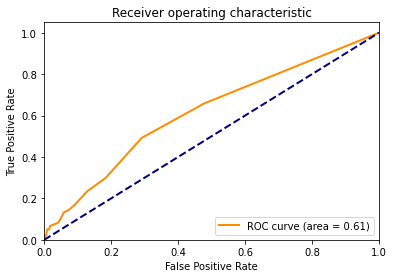

In [41]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Saving

In [ ]:
# We save the data for future plotting of all hypotheses in one figure, for the paper

In [42]:
with open('../data_for_plotting/ABCDchild_Hyp1_y_true_df.npy', 'wb') as f:
    np.save(f, y_true_df)
with open('../data_for_plotting/ABCDchild_Hyp1_y_cbcl_df.npy', 'wb') as f:
    np.save(f, y_cbcl_df)

In [43]:
#Checking
with open('../data_for_plotting/ABCDchild_Hyp1_y_true_df.npy', 'rb') as f:
    my_true_df = np.load(f)
with open('../data_for_plotting/ABCDchild_Hyp1_y_cbcl_df.npy', 'rb') as f:
    my_cbcl_df = np.load(f)

In [45]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(my_true, my_cbcl)
roc_auc = auc(fpr, tpr)
roc_auc

0.6142013888888888

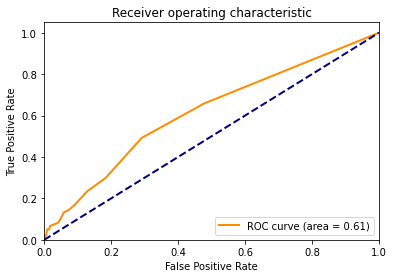

In [46]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Bootstrapping

In [40]:
boot_ind = np.random.choice(range(len(y_true_df)), size=y_true_df.size, replace=True)
boot_ind

array([706, 880, 669, ...,  21,  54, 136])

In [41]:
boot_truth = y_true_df[boot_ind]
boot_score = y_cbcl_df[boot_ind]
print(y_cbcl_df.head(5))
print(boot_score.head(5))

src_subject_id
NDAR_INVK71MV1Y2    60
NDAR_INVFXY9NVJE    50
NDAR_INVNACZ6DC5    56
NDAR_INV6XBTPUAH    68
NDAR_INVPN36DTAC    50
Name: cbcl_scr_dsm5_depress_t, dtype: int64
src_subject_id
NDAR_INVZ0LTAG73    52
NDAR_INVCBV85UMM    52
NDAR_INV26L6B73E    50
NDAR_INVRF8DNN59    52
NDAR_INVYLNHN7LR    50
Name: cbcl_scr_dsm5_depress_t, dtype: int64


In [42]:
def gen_auc_boots(scores, truth, nboots=100, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth[boot_ind]
        boot_score = scores[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

In [43]:
rng = np.random.default_rng()

target_auc = 0.8 # because we defined it this way. Change for Hyp 2b.

boots = gen_auc_boots(y_cbcl_df, y_true_df, nboots=1000, rng=rng)
boots = np.hstack([boots, np.array([sample_auc_score])])
p = (boots >= target_auc).mean()

In [47]:
print (min(boots))

0.5246708384714956


In [48]:
print (max(boots))

0.7025185841087126


# RESULTS

In [44]:
p_onesided = (boots >= target_auc).mean()
p_onesided

0.0

In [45]:
p_twosided1 = (boots > target_auc).mean()
p_twosided2 = (boots < target_auc).mean()
p_twosided = min(p_twosided1, p_twosided2)*2
p_twosided

0.0

In [ ]:
print(np.quantile(boots, .025))
print(np.quantile(boots, .975))
boots_mean_AUCROC = np.mean(boots)
print(boots_mean_AUCROC, '(', np.quantile(boots, .025), np.quantile(boots, .975), ')')

(array([  1.,   1.,   1.,   3.,   6.,  15.,  18.,  32.,  55.,  65.,  80.,
         99.,  96., 103.,  93.,  77.,  73.,  62.,  40.,  33.,  22.,   8.,
         12.,   3.,   3.]),
 array([0.52467084, 0.53178475, 0.53889866, 0.54601257, 0.55312648,
        0.56024039, 0.5673543 , 0.57446821, 0.58158212, 0.58869603,
        0.59580994, 0.60292385, 0.61003776, 0.61715167, 0.62426558,
        0.63137949, 0.6384934 , 0.64560731, 0.65272122, 0.65983513,
        0.66694903, 0.67406294, 0.68117685, 0.68829076, 0.69540467,
        0.70251858]),
 <BarContainer object of 25 artists>)

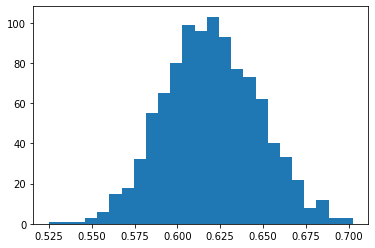

In [54]:
plt.hist(boots, bins=25)

### Exploratory - flipping the p-value estimation direction

In [56]:
rng = np.random.default_rng()

target_auc = 0.8 # because we defined it this way. Change for Hyp 2b.

boots = gen_auc_boots(y_cbcl_df, y_true_df, nboots=1000, rng=rng)
boots = np.hstack([boots, np.array([sample_auc_score])])
p = (boots < target_auc).mean()

In [57]:
p

1.0

# --- Confusion matrices for optimal thresholds ---

In [58]:
conf_fpr, conf_tpr, conf_thresh = roc_curve(y_true, y_cbcl)
conf_thresh

array([90, 89, 81, 78, 76, 75, 73, 72, 70, 68, 66, 65, 63, 60, 56, 52, 50])

In [59]:
roc_auc = auc(conf_fpr, conf_tpr)
roc_auc

0.6190432098765432

In [60]:
def predict_y(cbcl, threshold):
    y_score = []
    for item in y_cbcl:
        if item >= threshold:
            y_score.append(1)
        else:
            y_score.append(0)
    return y_score

In [61]:
# Create a dataframe for all data for thresholds and associated fpr, tpr, tp, tn, fp, fn

# and also euclidian distance
# --> tpr - y axis 
# --> fpr - x axis 
# We want to calculate an Euclidian distance to (0,1) for each point on the ROC curve and pick the point where that is minimized. 

## dist = sqrt((x2 - x1)^2 + (y2 - y1)^2) 
## dist = sqrt(square(x2 - x1) + square(y2 - y1)) 

# I will create the df from a list of lists

# first initiate the lists

all_roc_auc = []
all_fpr = []
all_tpr = []
all_tn = []
all_fp = []
all_fn = []
all_tp = []
all_thresholds = []
all_euclidian = []

# Point to calculate the Euclidian distance with - (0, 1)
optimal_performance = np.array((0, 1))

# now iterate through thesholds, calculate the values of interest, update the lists

for threshold in range (51,90):
    # predict diagnoses with the given threshold
    y_score = predict_y(y_cbcl, threshold)
    # calculate fp, fn, tp, tn, aucroc
    tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    # calculate euclidian
    fpr_tpr_datapoint = np.array((fpr, tpr))
    sum_sq = np.sum(np.square(optimal_performance - fpr_tpr_datapoint))
    euclidian = np.sqrt(sum_sq)
    
    # update all lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_tn.append(tn)
    all_fp.append(fp)
    all_fn.append(fn)
    all_tp.append(tp)
    all_thresholds.append(threshold)
    all_euclidian.append(euclidian)


# make a dataframe out of lists

conf_matrices_data = pd.DataFrame(list(zip(all_thresholds, all_euclidian, all_fpr, all_tpr, all_tp, all_tn, all_fp, all_fn)),
               columns =['threshold', 'Euclidian', 'FPR', 'TPR', 'TP', 'TN', 'FP', 'FN'])

conf_matrices_data

,threshold,Euclidian,FPR,TPR,TP,TN,FP,FN
0,51,0.588881,0.479630,0.658333,79,562,518,41
1,52,0.588881,0.479630,0.658333,79,562,518,41
2,53,0.581963,0.283333,0.491667,59,774,306,61
3,54,0.581963,0.283333,0.491667,59,774,306,61
4,55,0.581963,0.283333,0.491667,59,774,306,61
5,56,0.581963,0.283333,0.491667,59,774,306,61
6,57,0.721995,0.176852,0.300000,36,889,191,84
7,58,0.721995,0.176852,0.300000,36,889,191,84
8,59,0.721995,0.176852,0.300000,36,889,191,84
9,60,0.721995,0.176852,0.300000,36,889,191,84


In [63]:
# Find the best fpr/tpr pair

# What is the min euclidian distance in the dataframe?
conf_matrices_data[['Euclidian']].idxmin()

Euclidian    2
dtype: int64

In [64]:
conf_matrices_data.loc[2]

threshold     53.000000
Euclidian      0.581963
FPR            0.283333
TPR            0.491667
TP            59.000000
TN           774.000000
FP           306.000000
FN            61.000000
Name: 2, dtype: float64